# Multiple regression analysis in SQL with 3 independent variables
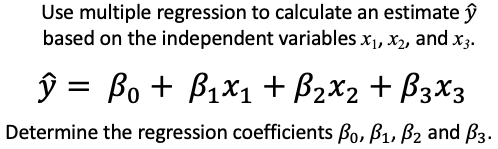

In [ ]:
import csv
import numpy as np
import pandas as pd
from pandas import DataFrame
from DATA225utils import make_connection, dataframe_query

## Read the values

In [ ]:
df = pd.read_csv('FourVariables.csv')
values = list(df.itertuples(index=False, name=None))

df

In [ ]:
conn = make_connection(config_file = 'FourVariables.ini')
cursor = conn.cursor()

In [ ]:
cursor.execute('DROP TABLE IF EXISTS variables')

sql = """
    CREATE TABLE variables
    (
        id INT    NOT NULL,
        x1 DOUBLE NOT NULL,
        x2 DOUBLE NOT NULL,
        x3 DOUBLE NOT NULL,
        y  DOUBLE NOT NULL,
        PRIMARY KEY(id)
    )
    """

cursor.execute(sql)

## Load the `variables` table

In [ ]:
sql = ( """
        INSERT INTO VARIABLES
        VALUES (%s, %s, %s, %s, %s)
        """
      )

cursor.executemany(sql, values)
conn.commit()

## Function to display the `variables` table and return its rows

In [ ]:
def display_and_return(cursor):
    """
    Query the variables table, print its rows as a dataframe,
    and return the rows as a numpy array.
    """
    _, df = dataframe_query(conn, 'SELECT * FROM variables')

    display(df)
    return df.to_numpy()

In [ ]:
rows = display_and_return(cursor)

## Regression coefficients using `numpy` matrix arithmetic

In [ ]:
import numpy as np
from numpy.linalg import inv

In [ ]:
X1 = rows[:, 1]
X2 = rows[:, 2]
X3 = rows[:, 3]
Y  = rows[:, 4]

In [ ]:
ones = np.array([1]*len(Y))
ones

In [ ]:
A = np.array([ones, X1, X2, X3]).T
A

In [ ]:
ATA = A.T@A

b = Y
ATb = A.T@b

ATAinv = inv(ATA)
Xhat = ATAinv@ATb

Xhat

In [ ]:
β0 = Xhat[0]
β1 = Xhat[1]
β2 = Xhat[2]
β3 = Xhat[3]

df = DataFrame([[β0, β1, β2, β3]])
df.columns = ['β0', 'β1', 'β2', 'β3']

display(df)

## Regression coefficients using `sklearn`

In [ ]:
Xs    = np.array([X1, X2, X3]).T
Betas = np.array([β1, β2, β3])

In [ ]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(X=Xs, y=Y)

β0 = linear_regression.intercept_
β1 = linear_regression.coef_[0]
β2 = linear_regression.coef_[1]
β3 = linear_regression.coef_[2]

df = DataFrame([[β0, β1, β2, β3]])
df.columns = ['β0', 'β1', 'β2', 'β3']

display(df)

## Function to execute multiple SQL statements

In [ ]:
def execute_multiple_SQL(cursor, sql, trace=False):
    """
    Use the cursor to execute multiple SQL statements.
    Print an execution trace if trace=True.
    """
    for crsr in cursor.execute(sql, multi=True):
        if crsr.with_rows:
            results = crsr.fetchall()
            if trace:
                print(crsr.statement)
                print('  ==> ', results)
        else:
            if trace:
                print(crsr.statement)
                if crsr.rowcount > 0:
                    print(f'  ==> {crsr.rowcount} row(s) affected.')

## Regression coefficients using SQL

In [ ]:
sql = ( """
    START TRANSACTION;

    DROP VIEW IF EXISTS base;
    DROP VIEW IF EXISTS regression_1;
    DROP VIEW IF EXISTS residuals_1;
    DROP VIEW IF EXISTS regression_2;
    DROP VIEW IF EXISTS residuals_2;
    DROP VIEW IF EXISTS multiple_regression_3;

    CREATE VIEW base AS
        SELECT
            x1,
            x1 - AVG(x1) OVER() AS x1_centered,

            x2,
            x2 - AVG(x2) OVER() AS x2_centered,

            x3,
            x3 - AVG(x3) OVER() AS x3_centered,

            y,
            y - AVG(y) OVER()   AS y_centered

        FROM variables;

    CREATE VIEW regression_1 AS
        SELECT
            AVG(x1) - AVG(x2) * SUM(x1_centered * x2_centered) 
                / SUM(x2_centered * x2_centered)                AS x1x2_const,
            SUM(x1_centered * x2_centered) 
                / SUM(x2_centered * x2_centered)                AS x1x2_coef,
            AVG(x1) - AVG(x3) * SUM(x1_centered * x3_centered) 
                / SUM(x3_centered * x3_centered)                AS x1x3_const,
            SUM(x1_centered * x3_centered) 
                / SUM(x3_centered * x3_centered)                AS x1x3_coef,
            AVG(x2) - AVG(x1) * SUM(x2_centered * x1_centered) 
                / SUM(x1_centered * x1_centered)                AS x2x1_const,
            SUM(x2_centered * x1_centered) 
                / SUM(x1_centered * x1_centered)                AS x2x1_coef,
            AVG(x2) - AVG(x3) * SUM(x2_centered * x3_centered) 
                / SUM(x3_centered * x3_centered)                AS x2x3_const,
            SUM(x2_centered * x3_centered) 
                / SUM(x3_centered * x3_centered)                AS x2x3_coef,
            AVG(x3) - AVG(x1) * SUM(x3_centered * x1_centered) 
                / SUM(x1_centered * x1_centered)                AS x3x1_const,
            SUM(x3_centered * x1_centered) 
                / SUM(x1_centered * x1_centered)                AS x3x1_coef,
            AVG(x3) - AVG(x2) * SUM(x3_centered * x2_centered) 
                / SUM(x2_centered * x2_centered)                AS x3x2_const,
            SUM(x3_centered * x2_centered) 
                / SUM(x2_centered * x2_centered)                AS x3x2_coef

        FROM base;

    CREATE VIEW residuals_1 AS
        SELECT
            y,
            y_centered,

            x1,
            x1_centered,
            x2,
            x2_centered,
            x3,
            x3_centered,

            x1 - (SELECT x1x2_coef  FROM regression_1) * x2 
               - (SELECT x1x2_const FROM regression_1)       AS x1x2_resid,
            x1 - (SELECT x1x3_coef  FROM regression_1) * x3 
               - (SELECT x1x3_const FROM regression_1)       AS x1x3_resid,
            x2 - (SELECT x2x1_coef  FROM regression_1) * x1 
               - (SELECT x2x1_const FROM regression_1)       AS x2x1_resid,
            x2 - (SELECT x2x3_coef  FROM regression_1) * x3 
               - (SELECT x2x3_const FROM regression_1)       AS x2x3_resid,
            x3 - (SELECT x3x1_coef  FROM regression_1) * x1 
               - (SELECT x3x1_const FROM regression_1)       AS x3x1_resid,
            x3 - (SELECT x3x2_coef  FROM regression_1) * x2 
               - (SELECT x3x2_const FROM regression_1)       AS x3x2_resid

        FROM base;

    CREATE VIEW regression_2 AS
        SELECT
            SUM(x1_centered * x2x3_resid) 
                / SUM(x2x3_resid * x2x3_resid)                  AS x1_x2x3_coef,
            SUM(x1_centered * x3x2_resid) 
                / SUM(x3x2_resid * x3x2_resid)                  AS x1_x3x2_coef,
            AVG(x1) - AVG(x2) * SUM(x1_centered * x2x3_resid) 
                          / SUM(x2x3_resid * x2x3_resid)
                    - AVG(x3) * SUM(x1_centered * x3x2_resid) 
                          / SUM(x3x2_resid * x3x2_resid)        AS x1_const,
            SUM(x2_centered * x1x3_resid) 
                / SUM(x1x3_resid * x1x3_resid)                  AS x2_x1x3_coef,
            SUM(x2_centered * x3x1_resid) 
                / SUM(x3x1_resid * x3x1_resid)                  AS x2_x3x1_coef,
            AVG(x2) - AVG(x1) * SUM(x2_centered * x1x3_resid) 
                          / SUM(x1x3_resid * x1x3_resid)
                    - AVG(x3) * SUM(x2_centered * x3x1_resid) 
                          / SUM(x3x1_resid * x3x1_resid)        AS x2_const,
            SUM(x3_centered * x2x1_resid) 
                / SUM(x2x1_resid * x2x1_resid)                  AS x3_x2x1_coef,
            SUM(x3_centered * x1x2_resid) 
                / SUM(x1x2_resid * x1x2_resid)                  AS x3_x1x2_coef,
            AVG(x3) - AVG(x1) * SUM(x3_centered * x1x2_resid) 
                          / SUM(x1x2_resid * x1x2_resid)
                    - AVG(x2) * SUM(x3_centered * x2x1_resid) 
                          / SUM(x2x1_resid * x2x1_resid)        AS x3_const

        FROM residuals_1;

    CREATE VIEW residuals_2 AS
        SELECT
            y,
            y_centered,

            x1,
            x1_centered,
            x2,
            x2_centered,
            x3,
            x3_centered,

            x1 - (SELECT x1_x2x3_coef FROM regression_2) * x2
               - (SELECT x1_x3x2_coef FROM regression_2) * x3
               - (SELECT x1_const FROM regression_2)           AS x1_resid,
            x2 - (SELECT x2_x1x3_coef FROM regression_2) * x1
               - (SELECT x2_x3x1_coef FROM regression_2) * x3
               - (SELECT x2_const FROM regression_2)           AS x2_resid,
            x3 - (SELECT x3_x1x2_coef FROM regression_2) * x1
               - (SELECT x3_x2x1_coef FROM regression_2) * x2
               - (SELECT x3_const FROM regression_2)           AS x3_resid

        FROM base;

    CREATE VIEW multiple_regression_3 AS
        SELECT
            AVG(y) - AVG(x1) * SUM(y_centered * x1_resid) 
                         / SUM(x1_resid * x1_resid)
                   - AVG(x2) * SUM(y_centered * x2_resid) 
                         / SUM(x2_resid * x2_resid)
                   - AVG(x3) * SUM(y_centered * x3_resid) 
                        / SUM(x3_resid * x3_resid)        AS beta0,
            SUM(y_centered * x1_resid) 
                / SUM(x1_resid * x1_resid)                AS beta1,
            SUM(y_centered * x2_resid) 
                / SUM(x2_resid * x2_resid)                AS beta2,
            SUM(y_centered * x3_resid) 
                / SUM(x3_resid * x3_resid)                AS beta3

        FROM residuals_2;

    COMMIT;
    """
      )

In [ ]:
execute_multiple_SQL(cursor, sql)

In [ ]:
cursor.execute('SELECT * FROM multiple_regression_3')
result = cursor.fetchone()

result

In [ ]:
β0, β1, β2, β3 = result

df = DataFrame([[β0, β1, β2, β3]])
df.columns = ['β0', 'β1', 'β2', 'β3']

display(df)

In [ ]:
X     = np.array([X1, X2, X3]).T
Betas = np.array([β1, β2, β3])

Yhat = []

for x in X:
    Yhat.append(x@Betas + β0)

In [ ]:
Errors = Y - Yhat
table = []

for i in range(len(Y)):
    pct = abs(100*Errors[i]/Y[i])
    row = np.concatenate([X[i], [Y[i], Yhat[i], Errors[i], pct]])
    
    table.append(row)

In [ ]:
df = DataFrame(table)
df.columns = ['x1', 'x2', 'x3', 'y', 
              'est. y', 'error', '% error']

pd.options.display.float_format = '{:,.2f}'.format
display(df)

print(f'correlation coefficient = {np.corrcoef(Y, Yhat)[0, 1]:.2f}')

#### (c) 2023 by Ronald Mak